In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import folium

In [3]:
# note that this is in epsg 4326
sg = gpd.read_file("singapore.geojson")

# First, convert to UTM 48N to get values in meters
sg = sg.to_crs("EPSG:32648")

sg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 161 entries, 0 to 160
Columns: 245 entries, id to geometry
dtypes: geometry(1), object(244)
memory usage: 308.3+ KB


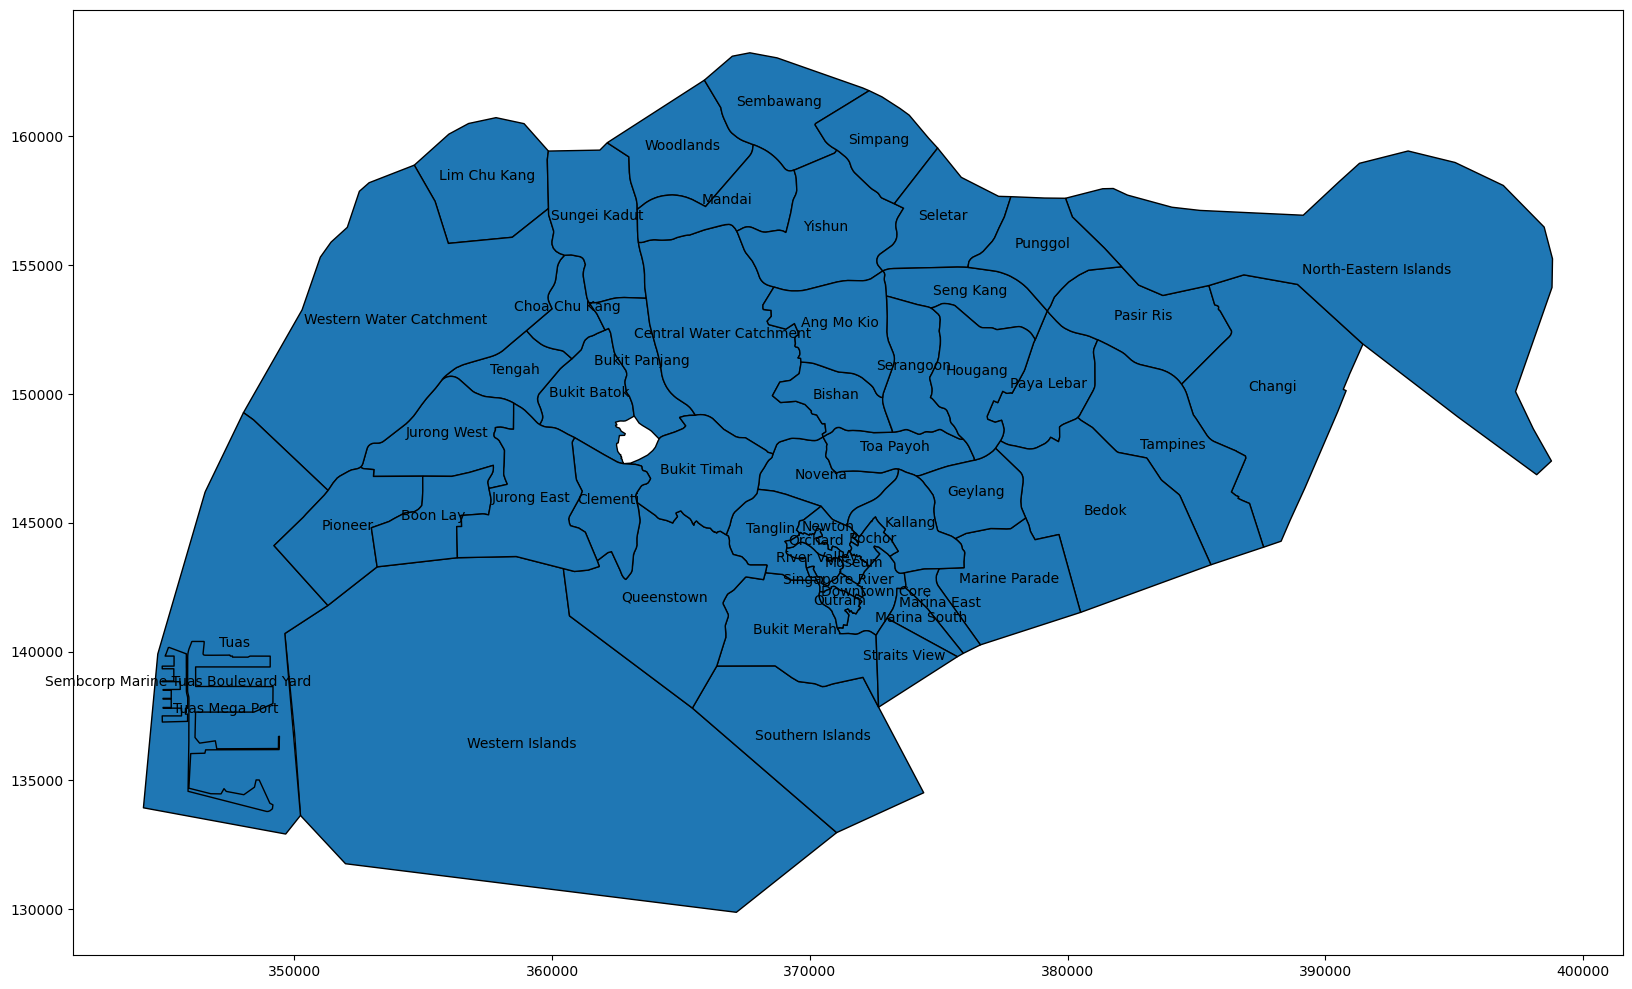

In [5]:
# We start by preprocessing the Singapore suburb boundary data
sg_suburbs = sg[sg["place"] == "suburb"][["name", "geometry"]]

# For some reason there is a Jurong East area as well as Toh Yi Drive area that is not included in the 
# OSM data: we'll need to add these polygons into the shape file
sg_suburbs = sg_suburbs[sg_suburbs.geometry.geom_type.isin(["Polygon", "Multipolygon"])]
je = sg[(sg["place"] == "city") & (sg["name"] == "Jurong East")][["name", "geometry"]]

# Add jurong east
sg_suburbs = pd.concat([sg_suburbs, je])

# Drop duplicate names (Tengah)
sg_suburbs = sg_suburbs.drop_duplicates(subset = "name")

# %matplotlib qt5
fig, ax = plt.subplots(figsize = (20,24))
sg_suburbs.plot(ax = ax, edgecolor = "black")

sg_suburbs.apply(lambda x: ax.annotate(text = x["name"], 
                                       xy = x["geometry"].centroid.coords[0],
                                       ha = "center"), axis = 1)
plt.show();

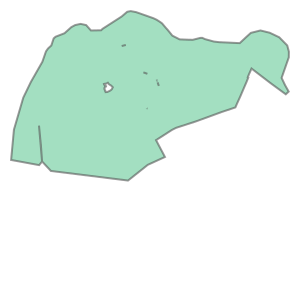

In [6]:
# Running unary_union is a good way for checking if there are any gaps in the Polygon data
# we can see that in addition to the toe drive area there are some gaps between the polygons in 
# other parts of Singapore that we will need to fix
sg_suburbs.unary_union

In [134]:
# Let's try and add the Toh Yi Drive area to Bukit Timah

# First, buffer the geometry
bt_poly = sg_suburbs[sg_suburbs["name"] == "Bukit Timah"]["geometry"]

sg_suburbs.plot()
x,y = bt_poly.iloc[0].exterior.xy
plt.plot(x, y, color = "red")

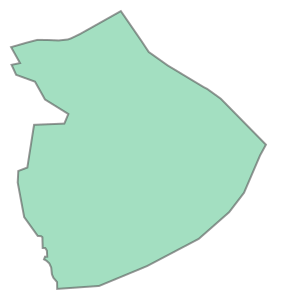

In [135]:
# Let's try and add the Toh Yi Drive area to Bukit Timah
from shapely.geometry import Polygon

# We manually create a rectangular polygon
# Define the coordinates of the polygon's exterior ring
# the coords are given by bottom right, top right, top left, bottom left
coordinates = [(362000, 147000), (362000, 149500), (364500, 149500), (364500, 147000)]
manual_poly = Polygon(coordinates)

# # Use this to visualize if you've got the right polygon
# sg_suburbs.plot()
# x,y = bt_poly.iloc[0].exterior.xy
# plt.plot(x, y, color = "red")
# a,b = manual_poly.exterior.xy
# plt.plot(a, b, color = "green")

# We then find the difference between this polygon and the unary_union of the entire dataset
ty_poly = manual_poly.difference(sg_suburbs.unary_union)

ty_poly

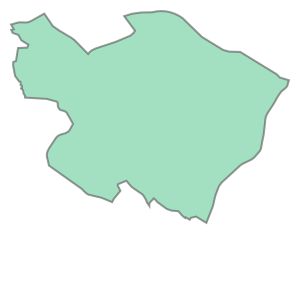

In [136]:
# Combine the old BT poly and the TY poly into a new merged polygon
from shapely.ops import unary_union

merged_poly = unary_union([ty_poly, bt_poly.iloc[0]])

merged_poly

In [137]:
# Set the merged poly as the new BT poly
sg_suburbs.loc[sg_suburbs["name"] == "Bukit Timah", "geometry"] = merged_poly

# worked
sg_suburbs.plot()

<Axes: >

In [138]:
fig, ax = plt.subplots(figsize = (20,24))
sg_suburbs.plot(ax = ax, edgecolor = "black")

sg_suburbs.apply(lambda x: ax.annotate(text = x["name"], 
                                       xy = x["geometry"].centroid.coords[0],
                                       ha = "center"), axis = 1)
plt.show();

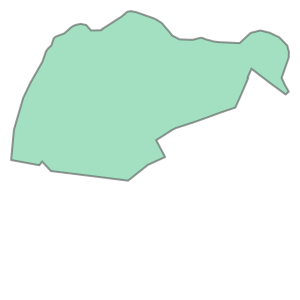

In [78]:
sg_suburbs.geometry.buffer(25).unary_union

In [139]:
# https://stackoverflow.com/questions/71738629/expand-polygons-in-geopandas-so-that-they-do-not-overlap-each-other
# First let's identify any small areas that are missing - this will likely be due to misalignments in 
# the original polygons

# Apparently the best way to fix small gaps between polygons due to misalignments is by buffering 
# all the polygons and then identifying any overlaps and using the Geo pandas intersection tool 
# to distribute those overlaps into one of two adjacent polygons
from itertools import combinations

# Full polygon of singapore based on sg_suburbs
sg_poly = Polygon([i for i in sg_suburbs.unary_union.exterior.coords])

# multipolygon of all the missing bits
missing = sg_poly.difference(sg_suburbs.unary_union)

# Missing has a geoms property containing all the polygons in the multipolygon
# TRY: for each polygon, find the nearest suburb (using centroid), then merge the two polygons
for polygon in missing.geoms:
    # This finds the geometry of the suburb that is CLOSEST to the missing polygon,
    # and merges them
    merged = unary_union([sg_suburbs.loc[sg_suburbs.centroid.distance(polygon).idxmin(), "geometry"], polygon])
    
    # Replace the original suburb polygon with the merge
    # Note that this can leave some extremely small missing polygons on the order of centimetre 
    # scale due to floating point errors with the unary union function
    sg_suburbs.loc[sg_suburbs.centroid.distance(polygon).idxmin(), "geometry"] = merged

In [148]:
fig, ax = plt.subplots(figsize = (20,24))
sg_suburbs.plot(ax = ax, edgecolor = "black")

sg_suburbs.apply(lambda x: ax.annotate(text = x["name"], 
                                       xy = x["geometry"].centroid.coords[0],
                                       ha = "center"), axis = 1)

plt.show();

In [147]:
# Full polygon of singapore based on sg_suburbs
sg_poly = Polygon([i for i in sg_suburbs.unary_union.exterior.coords])

# multipolygon of all the missing bits
missing = sg_poly.difference(sg_suburbs.unary_union)

# Apparently the best way to fix this is to buffer your Polygon by an extremely small amount and 
# then unbuffer the Polygon by the same amount

# Newton is the closest polygon.
print(sg_suburbs.loc[sg_suburbs.centroid.distance(missing).idxmin(), "name"])

# buffer then unbuffer, save to original polygon
sg_suburbs.loc[sg_suburbs.centroid.distance(missing).idxmin(), "geometry"] = sg_suburbs.loc[sg_suburbs.centroid.distance(missing).idxmin(), "geometry"].buffer(1).buffer(-1)

Newton


In [ ]:
# Full polygon of singapore based on sg_suburbs
sg_poly = Polygon([i for i in sg_suburbs.unary_union.exterior.coords])

# multipolygon of all the missing bits
missing = sg_poly.difference(sg_suburbs.unary_union)

# Nothing left!
missing

In [151]:
sg_suburbs.to_file("sg_suburbs_cleaned.geojson", driver = "GeoJSON")

In [80]:
### ALTERNATIVE METHOD OF FILLING GAPS ###
# # Note that this method actually does increase the size of all polygons by the amount that 
# # you buffer - you want your buffer size to be as small as possible while still filling in all 
# # the gaps - use unary_union to check if gaps remain for a given buffer size
# sg_suburbs.geometry.buffer(25).unary_union

# # sg_suburbs.geometry = sg_suburbs.geometry.buffer(25)

# # The combinations function finds all combinations between pairs of elements that you pass it
# poly = sg_suburbs.geometry.buffer(25)
# for p1_idx, p2_idx in combinations(poly.index, 2):
#     if poly.loc[p1_idx].intersects(poly.loc[p2_idx]):
#         # Store intermediary results back to poly
#         # Apparently subtracting a polygon is the same as 
#         # poly.loc[p2_idx].difference(poly.loc[p1_idx])
#         poly.loc[p2_idx] -= poly.loc[p1_idx]
        
# sg_suburbs.geometry = poly
# sg_suburbs.unary_union

(array('d', [346538.25796076504, 348024.93576193426, 350300.08955645876, 351008.0060041412, 351423.79716657824, 352054.4578831537, 352523.2348022208, 352900.6663771364, 354653.54656416195, 355996.0471905739, 356760.3040515541, 357825.2741796749, 358913.85801314376, 359857.0101465669, 361854.7116624045, 362139.7534985817, 365910.6983046497, 366993.342850052, 367674.85243506456, 368731.73886743386, 372050.43675808026, 372303.9017967801, 372801.563023688, 373502.89225105086, 373858.18642917316, 374613.94814773765, 374960.851131886, 375878.0904922312, 377327.5950445174, 377804.6663371939, 379110.65766825783, 379922.1337524892, 381364.1731074193, 381774.80442544154, 382328.55985348934, 384052.02398114256, 385140.6071417469, 389146.48967623385, 390541.26222546224, 391329.37566374853, 393215.5357983719, 395039.23867111123, 396910.49911800993, 398495.01079842565, 398819.1945807316, 398799.67275951325, 397384.81873194943, 398071.82926331344, 398778.0132946835, 398204.8534926757, 395149.85915371

In [66]:
# sg_boundary = gpd.read_file("singapore_island_boundary.geojson")
# sg_boundary = sg_boundary.to_crs("EPSG:32648")
# sg_boundary = sg_boundary[sg_boundary.geometry.geom_type.isin(["Polygon", "Multipolygon"])]

# missing = sg_boundary.unary_union.difference(sg_suburbs.unary_union)

# fig, ax = plt.subplots()
# sg_boundary.plot(ax = ax)
# sg_suburbs.plot(ax = ax, edgecolor = "black")
# # This is how you plot multipolygons
# for polygon in missing.geoms:
#     x,y = polygon.exterior.xy
#     plt.plot(x, y, color = "red")

In [159]:
# Save sg_poly as dataframe
sg_poly = gpd.GeoDataFrame({"name": "Singapore", "geometry": sg_poly}, index = [0], crs = "EPSG:32648").to_crs("EPSG:4236")

sg_poly.to_file("singapore_boundary.geojson", driver = "GeoJSON")

ValueError: 2